In [1]:
# Set JAX_PLATFORMS=''
import os
# os.environ["JAX_PLATFORMS"] = "cpu"
from flaxdiff.inference.pipeline import DiffusionInferencePipeline

/home/mrwhite0racle/miniconda3/envs/flaxdiff/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-05 22:50:43.790627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746485443.814407  475694 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746485443.821742  475694 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746485443.839308  475694 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target

In [2]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

def normalizeImage(x): return jax.nn.standardize(x, mean=[127.5], std=[127.5])
def denormalizeImage(x): return (x + 1.0) * 127.5


def plotImages(imgs, fig_size=(8, 8), dpi=100):
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    imglen = imgs.shape[0]
    for i in range(imglen):
        plt.subplot(fig_size[0], fig_size[1], i + 1)
        plt.imshow(jnp.astype(denormalizeImage(imgs[i, :, :, :]), jnp.uint8))
        plt.axis("off")
    plt.show()

In [ ]:
pipeline = DiffusionInferencePipeline.from_wandb_registry(
    modelname="diffusion-laiona_coco-res256",
    project='mlops-msml605-project',
    entity='umd-projects',
    version='best',
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Downloading large artifact diffusion-laiona_coco-res256:best, 2149.83MB. 17 files... 
wandb:   17 of 17 files downloaded.  
Done. 0:0:3.4


Loaded model from wandb registry: diffusion-laiona_coco-res256 at path /home/mrwhite0racle/persist/mlops-diffusion-project/artifacts/diffusion-laiona_coco-res256:v22


Loaded checkpoint from local dir /home/mrwhite0racle/persist/mlops-diffusion-project/artifacts/diffusion-laiona_coco-res256:v22
Using autoencoder: stable_diffusion
Using Stable Diffusion Autoencoder for Latent Diffusion Modeling
Scaling factor: 0.18215
Calculating downscale factor...


In [ ]:
a = 'a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful forest with a river and sunlight, a beautiful forest with a river and sunlight, a beautiful forest with a river and sunlight, a beautiful forest with a river and sunlight, a beautiful forest with a river and sunlight, a beautiful forest with a river and sunlight, a beautiful forest with a river and sunlight, a beautiful forest with a river and sunlight, a big mansion with a garden, a big mansion with a garden, a big mansion with a garden, a big mansion with a garden, a big mansion with a garden, a big mansion with a garden, a big mansion with a garden, a big mansion with a garden'
prompts = a.split(',')
prompts = [x.strip() for x in prompts]

Created null embeddings for guidance with shape (1, 77, 768)
Using classifier-free guidance
Generating samples: steps=200, num_samples=8, guidance=3.0
Processing raw conditioning inputs to generate model conditioning inputs


100%|██████████| 200/200 [00:30<00:00,  6.61it/s]


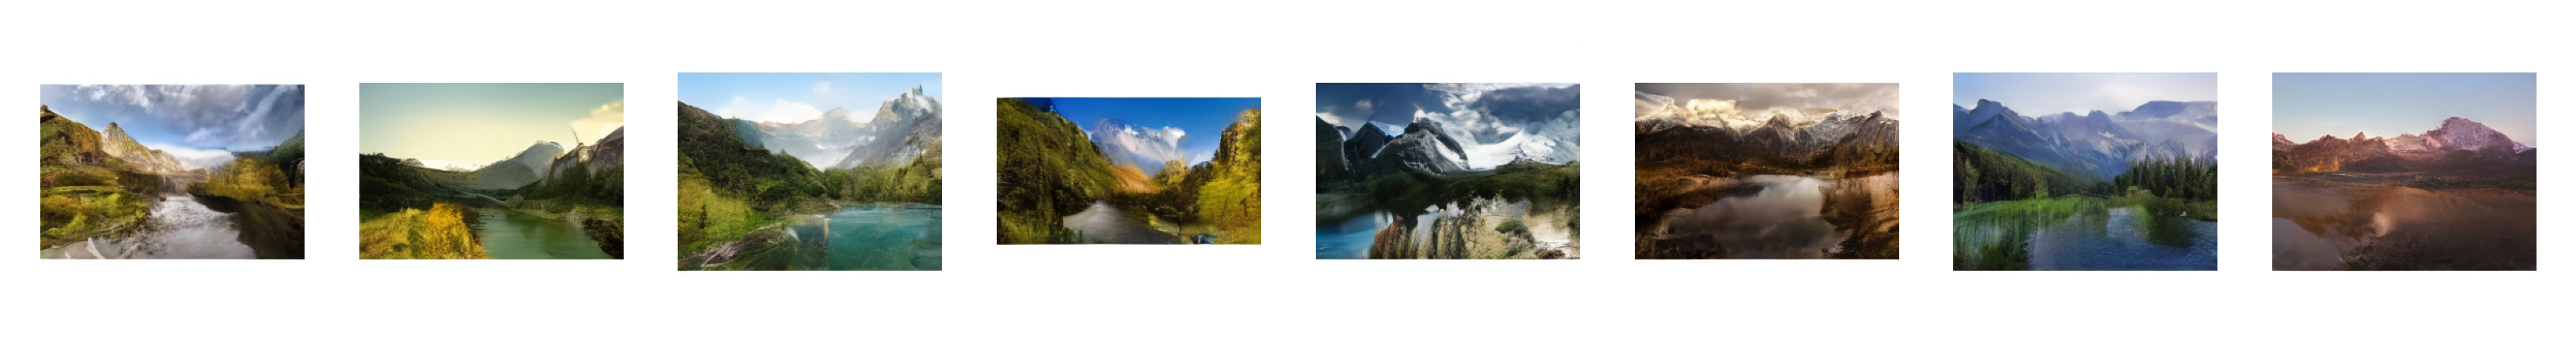

In [ ]:
a = 'a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful landscape with a river with mountains, a beautiful forest with a river and sunlight, a beautiful forest with a river and sunlight, a beautiful forest with a river and sunlight, a beautiful forest with a river and sunlight, a beautiful forest with a river and sunlight, a beautiful forest with a river and sunlight, a beautiful forest with a river and sunlight, a beautiful forest with a river and sunlight, a big mansion with a garden, a big mansion with a garden, a big mansion with a garden, a big mansion with a garden, a big mansion with a garden, a big mansion with a garden, a big mansion with a garden, a big mansion with a garden'
prompts = a.split(',')
prompts = [x.strip() for x in prompts][:8]

samples = pipeline.generate_samples(
    num_samples=len(prompts),
    resolution=256,
    diffusion_steps=200,
    guidance_scale=3.0,
    start_step=1000,
    conditioning_data=prompts,
)
plotImages(samples, dpi=500)

In [3]:
import tqdm
import grain.python as pygrain
import torch
from flaxdiff.samplers.euler import EulerAncestralSampler
import numpy as np

class EvaluationPipeline(DiffusionInferencePipeline):
    from torchmetrics.image.fid import FrechetInceptionDistance
    from torchmetrics.image.kid import KernelInceptionDistance
    from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fid = self.FrechetInceptionDistance()
        self.kid = self.KernelInceptionDistance(subset_size=32)
        self.lpip = self.LearnedPerceptualImagePatchSimilarity()
        import wandb
        self.wandb = wandb.init(
            project='mlops-evaluations',
            entity='umd-projects',
            name=self.name,
            job_type='evaluation',
            config=self.config,
        ) 
        
    def compute_metrics(self, original_images, generated_images):
        """
        Computes FID, KID, and LPIPS metrics between original and generated images.
        All images should be in the range [0, 255].
        """
        self.fid.update(original_images, real=True)  
        self.fid.update(generated_images, real=False)
        
        self.kid.update(original_images, real=True)
        self.kid.update(generated_images, real=False)
        
        # LPIPS expects images in the range [0, 1]
        original_images = original_images / 255.0
        generated_images = generated_images / 255.0
        self.lpip.update(original_images, generated_images)
        
        fid_score = self.fid.compute()
        kid_score = self.kid.compute()
        lpips_score = self.lpip.compute()
        
        return {
            'FID': fid_score,
            'KID': kid_score,
            'LPIPS': lpips_score
        }
    
    def evaluate(
        self, 
        dataloader: pygrain.DataLoader, 
        diffusion_steps=50, 
        sampler_class=EulerAncestralSampler,
        iterations=20,
        batch_size=8,
        image_size=256,
    ):
        metrics_history = {}
        iterator = iter(dataloader)
        for i in range(iterations):
            batch = next(iterator)
            original_images = batch['image']
            conditions = batch['text']
            model_conditioning_inputs = self.input_config.conditions[0].encoder.encode_from_tokens(conditions)
            
            generated = self.generate_samples(
                num_samples=batch_size,
                resolution=image_size,
                diffusion_steps=diffusion_steps,
                guidance_scale=3.0,
                start_step=1000,
                sampler_class=sampler_class,
                conditioning_data_tokens=(model_conditioning_inputs,)
            )
            
            # Calculate metrics
            # Original images are in [0, 255]. Generated images are in [-1, 1]
            generated_255 = (generated * 127.5 + 127.5).astype(jnp.uint8)
            original_255 = original_images.astype(jnp.uint8)
            
            # Convert to torch tensors
            original_255 = torch.from_numpy(original_255).permute(0, 3, 1, 2)
            generated_255 = torch.from_numpy(np.array(generated_255)).permute(0, 3, 1, 2)
            
            metrics = self.compute_metrics(original_255, generated_255)            
            for key, value in metrics.items():
                if key not in metrics_history:
                    metrics_history[key] = []
                metrics_history[key].append(value)
            
            print(f"Iteration {i + 1}/{iterations}: FID: {metrics['FID']}, KID: {metrics['KID']}, LPIPS: {metrics['LPIPS']}")
            
            # Plot the images
            if i % 5 == 0:
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.imshow(generated_255[0].permute(1, 2, 0).numpy())
                plt.title("Generated Image")
                plt.axis("off")
                plt.subplot(1, 2, 2)
                plt.imshow(original_255[0].permute(1, 2, 0).numpy())
                plt.title("Original Image")
                plt.axis("off")
                plt.show()
            
        # Average the metrics over all batches
        for key, value in metrics_history.items():
            metrics_history[key] = jnp.mean(jnp.array(value))
        
        # TODO: Push these metrics to wandb model registry
        self.wandb.log(metrics_history)
        self.wandb.log({"metrics": metrics_history})
        
        # push to registry
        self.push_to_registry()
            
            
        return metrics_history
    
    def push_to_registry(
        self,
        registry_name: str = 'wandb-registry-model',
        aliases = [],
    ):
        """
        Push the model to wandb registry.
        Args:
            registry_name: Name of the model registry.
            aliases: List of aliases for the model.
        """
        modelname = self.config['raw_config']['modelname']
        target_path = f"{registry_name}/final-{modelname}"
        
        self.wandb.link_artifact(
            artifact=self.artifact,
            target_path=target_path,
            aliases=aliases,
        )
        print(f"Model pushed to registry at {target_path}")
        return target_path

In [ ]:
pipeline = EvaluationPipeline.from_wandb_registry(
    modelname="diffusion-laiona_coco-res256",
    project='mlops-msml605-project',
    entity='umd-projects',
    version='best',
)

wandb: Downloading large artifact diffusion-laiona_coco-res256:best, 2149.83MB. 17 files... 
wandb:   17 of 17 files downloaded.  
Done. 0:0:3.4


Loaded model from wandb registry: diffusion-laiona_coco-res256 at path /home/mrwhite0racle/persist/mlops-diffusion-project/artifacts/diffusion-laiona_coco-res256:v22
Loaded checkpoint from local dir /home/mrwhite0racle/persist/mlops-diffusion-project/artifacts/diffusion-laiona_coco-res256:v22
Using autoencoder: stable_diffusion
Using Stable Diffusion Autoencoder for Latent Diffusion Modeling
Scaling factor: 0.18215
Calculating downscale factor...
Downscale factor: 8
Latent channels: 4


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing FlaxCLIPTextModel: {('vision_model', 'encoder', 'layers', '14', 'self_attn', 'q_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '18', 'mlp', 'fc1', 'bias'), ('vision_model', 'encoder', 'layers', '10', 'mlp', 'fc1', 'kernel'), ('vision_model', 'encoder', 'layers', '7', 'self_attn', 'v_proj', 'bias'), ('vision_model', 'encoder', 'layers', '19', 'self_attn', 'q_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '8', 'layer_norm1', 'bias'), ('vision_model', 'encoder', 'layers', '8', 'self_attn', 'k_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '3', 'self_attn', 'k_proj', 'bias'), ('vision_model', 'encoder', 'layers', '20', 'layer_norm1', 'scale'), ('vision_model', 'encoder', 'layers', '16', 'self_attn', 'k_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '13', 'self_attn', 'k_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '13', 'mlp', 'fc2', 'kernel')

Model kwargs after mapping: {'dtype': <class 'jax.numpy.float32'>, 'in_channels': 4, 'sample_size': 32, 'out_channels': 4, 'layers_per_block': 2, 'attention_head_dim': 8, 'block_out_channels': [64, 128, 256, 512], 'cross_attention_dim': 512, 'only_cross_attention': True, 'use_memory_efficient_attention': False}


wandb: Currently logged in as: ashishkumar4 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


BrokenPipeError: [Errno 32] Broken pipe

: 

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = 256
from flaxdiff.data.dataloaders import get_dataset_grain
data = get_dataset_grain(
    "laiona_coco",
    batch_size=BATCH_SIZE,
    image_scale=IMAGE_SIZE,
    dataset_source="/home/mrwhite0racle/gcs_mount",
    method=None
)

datalen = data['train_len']
batches = datalen // BATCH_SIZE

Using method: 3


/home/mrwhite0racle/miniconda3/envs/flaxdiff/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/mrwhite0racle/miniconda3/envs/flaxdiff/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/mrwhite0racle/miniconda3/envs/flaxdiff/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the enviro

Generating samples: steps=200, num_samples=128, guidance=3.0










































































































































































































100%|██████████| 200/200 [01:09<00:00,  2.89it/s]


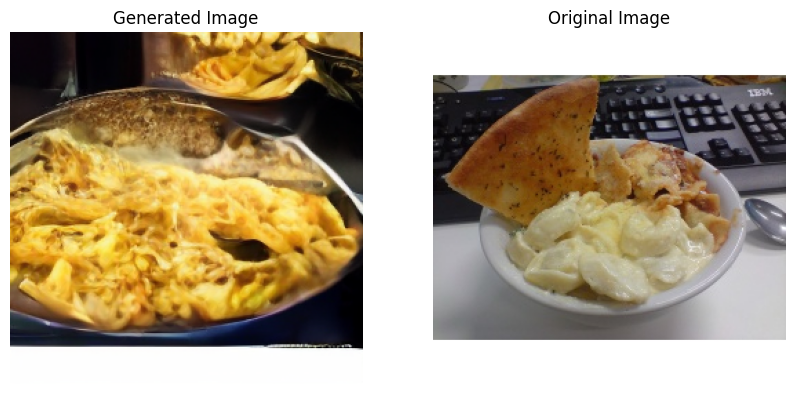

Generating samples: steps=200, num_samples=128, guidance=3.0










































































































































































































100%|██████████| 200/200 [00:22<00:00,  8.78it/s]


Generating samples: steps=200, num_samples=128, guidance=3.0










































































































































































































100%|██████████| 200/200 [00:23<00:00,  8.55it/s]


Generating samples: steps=200, num_samples=128, guidance=3.0










































































































































































































100%|██████████| 200/200 [00:23<00:00,  8.56it/s]


Generating samples: steps=200, num_samples=128, guidance=3.0










































































































































































































100%|██████████| 200/200 [00:23<00:00,  8.58it/s]


Generating samples: steps=200, num_samples=128, guidance=3.0










































































































































































































100%|██████████| 200/200 [00:23<00:00,  8.52it/s]


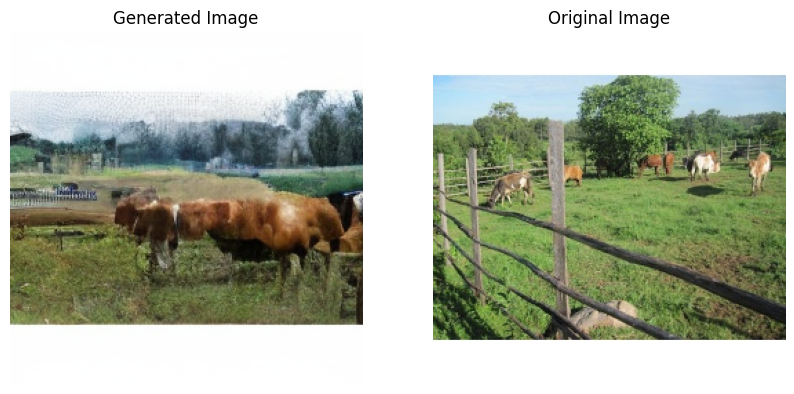

Generating samples: steps=200, num_samples=128, guidance=3.0


In [ ]:
pipeline.evaluate(
    dataloader=data['train'](),
    diffusion_steps=200,
    sampler_class=EulerAncestralSampler,
    iterations=10,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)

In [ ]:
batch = next(iter(data['train']()))

In [ ]:
images = torch.from_numpy(batch['image'])

In [ ]:
# BHWC TO BCHW
images2 = images.permute(0, 3, 1, 2)

In [ ]:
images2.shape

torch.Size([32, 3, 256, 256])

In [ ]:
fid = pipeline.fid

In [ ]:
# imgs_dist1 = torch.randint(0, 200, (100, 3, 256, 256), dtype=torch.uint8)
# imgs_dist2 = torch.randint(100, 255, (100, 3, 299, 299), dtype=torch.uint8)
fid.update(images2, real=True)
fid.update(images2, real=False)

In [ ]:
images2.shape

torch.Size([32, 3, 256, 256])

In [ ]:
pipeline.compute_metrics(
    original_images=images2,
    generated_images=images2,
)

TypeError: LearnedPerceptualImagePatchSimilarity.update() got an unexpected keyword argument 'generated'

In [ ]:
import wandb

api = wandb.Api()

In [61]:
def get_best_score(run):
    return run.history(keys=['val/clip_similarity']).min()['val/clip_similarity']

def get_best_version(run):
    models = [i for i in run.logged_artifacts() if i.type == 'model']
    highest_version = max([{'version':int(i.version[1:]), 'name': i.qualified_name} for i in models], key=lambda x: x['version'])
    wandb_modelname = highest_version['name']
    artifact = run.use_artifact(wandb.Api().artifact(wandb_modelname))
    return artifact

In [62]:
get_best_version(all_runs[0])

<Artifact QXJ0aWZhY3Q6MTcwOTI5MDE2NA==>

In [52]:
target = "umd-projects/mlops-msml605-project"
all_runs = [i for i in api.runs(path=target, filters={"config.dataset.name": "laiona_coco"})]
all_runs = sorted(all_runs, key=lambda x: get_best_score(x))

In [53]:
for run in all_runs:
    print(get_best_score(run))

0.7900390625
0.80322265625
0.8056640625
0.80615234375
0.80908203125
0.8115234375
0.8134765625
0.814453125
0.81494140625
0.81640625
0.8203125
0.822265625
0.82763671875
0.83203125
0.83251953125
0.83740234375
0.8466796875
0.89306640625


In [ ]:

for run in all_runs[::-1]:
    try:
        print(get_best_score(run))
        best_version = get_best_version(run)
        print(f"Best version for run {run.id}: {best_version}")
        # Push the model to registry
        wandb_run = wandb.init(
            project='mlops-msml605-project',
            entity='umd-projects',
            id=run.id,
            resume='must',
        )   
        wandb_run.link_artifact(
            artifact=best_version,
            target_path=f"wandb-registry-model/diffusion-laiona_coco-res256",
            aliases=['best'] if run.id == all_runs[0].id else [],
        )
        print(f"Model pushed to registry at wandb-registry-model/diffusion-laiona_coco-res256")
    except Exception as e:
        print(f"Error pushing model for run {run.id}: {e}")
        continue

0.7900390625


wandb: ERROR Unable to save notebook session history.


Best version for run be4s4ehl: <Artifact QXJ0aWZhY3Q6MTcwOTI5MDE2NA==>


train/avg_loss,0.33153
train/avg_time_per_step,0.11147
train/best_loss,0.33153
train/epoch,16
train/epoch_time,5573.64865
train/loss,0.32992
train/step,904013
val/clip_similarity,0.80908


Model pushed to registry at wandb-registry-model/diffusion-laiona_coco-res256


In [9]:
run = all_runs[0]

In [41]:
run.history(keys=['val/clip_similarity']).min()['val/clip_similarity']

np.float64(0.80322265625)

In [38]:
a['val/clip_similarity']

np.float64(0.80322265625)

In [28]:
artifacts = [i for i in api.artifacts(type_name="model", name="wandb-registry-model/diffusion-laiona_coco-res256")]

In [29]:
artifacts[0].version

'v26'

In [51]:
get_best_score(artifacts[0].logged_by())

np.float64(0.89306640625)